In [ ]:
# load the necessary module
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy import stats
import matplotlib
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import auc
cmap_rock = LinearSegmentedColormap.from_list('rg',["orangered", "green"], N=2) 
warnings.filterwarnings("ignore")

# load plot setting parameters
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 17.5})
# plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.titlepad'] = 15

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!jupyter nbconvert --to html /content/HW4.ipynb  

[NbConvertApp] Converting notebook /content/HW4.ipynb to html
[NbConvertApp] Writing 7210922 bytes to /content/HW4.html


In [ ]:
## Clone data from our GitHub repository
! git clone https://github.com/lijingwang/GEOLSCI6_EARTHSYS100A.git
# load landslides dataset
landslides_dataset = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/Ch3_SpatialAggregation/LogisticRegression/landslides_himalaya.csv',sep = ',')
landslides_dataset.head(3)

Cloning into 'GEOLSCI6_EARTHSYS100A'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 475 (delta 147), reused 170 (delta 70), pack-reused 203
Receiving objects: 100% (475/475), 58.28 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (233/233), done.


landslide  elevation  aspect  slope   wetness      ndvi      ndwi  curvature
0        0.0     5242.0   335.0   14.0  0.320446 -0.013182  0.606071        0.0
1        0.0     5718.0     8.0   21.0  0.376848 -0.048040  0.817809     -186.0
2        0.0     6008.0    85.0   12.0  0.376848 -0.025214  0.596792     -539.0

Description of the dataset

Data size: 150 x 270 Pixels

Each column(vector)represents one predictor with length 40500 (150x270)

In [ ]:
independent_variables = landslides_dataset.drop(['landslide'], axis = 1)
independent_variables.head(3)

elevation  aspect  slope   wetness      ndvi      ndwi  curvature
0     5242.0   335.0   14.0  0.320446 -0.013182  0.606071        0.0
1     5718.0     8.0   21.0  0.376848 -0.048040  0.817809     -186.0
2     6008.0    85.0   12.0  0.376848 -0.025214  0.596792     -539.0

In [ ]:
dependent_variables = landslides_dataset['landslide']
num_slide = dependent_variables.value_counts()[1]
dependent_variables.value_counts()

0.0    40292
1.0      208
Name: landslide, dtype: int64

In [ ]:
x_dim = 270
y_dim = 150
x = np.arange(0, x_dim, 1)
y = np.arange(0, y_dim, 1)
X, Y = np.meshgrid(x, y)

forPlot = pd.DataFrame([], columns = ['x', 'y', 'landslide'])
forPlot['x'] =np.ravel(X)
forPlot['y'] = np.ravel(Y)
forPlot['landslide'] = np.ravel(dependent_variables.values.reshape(x_dim,y_dim).T)

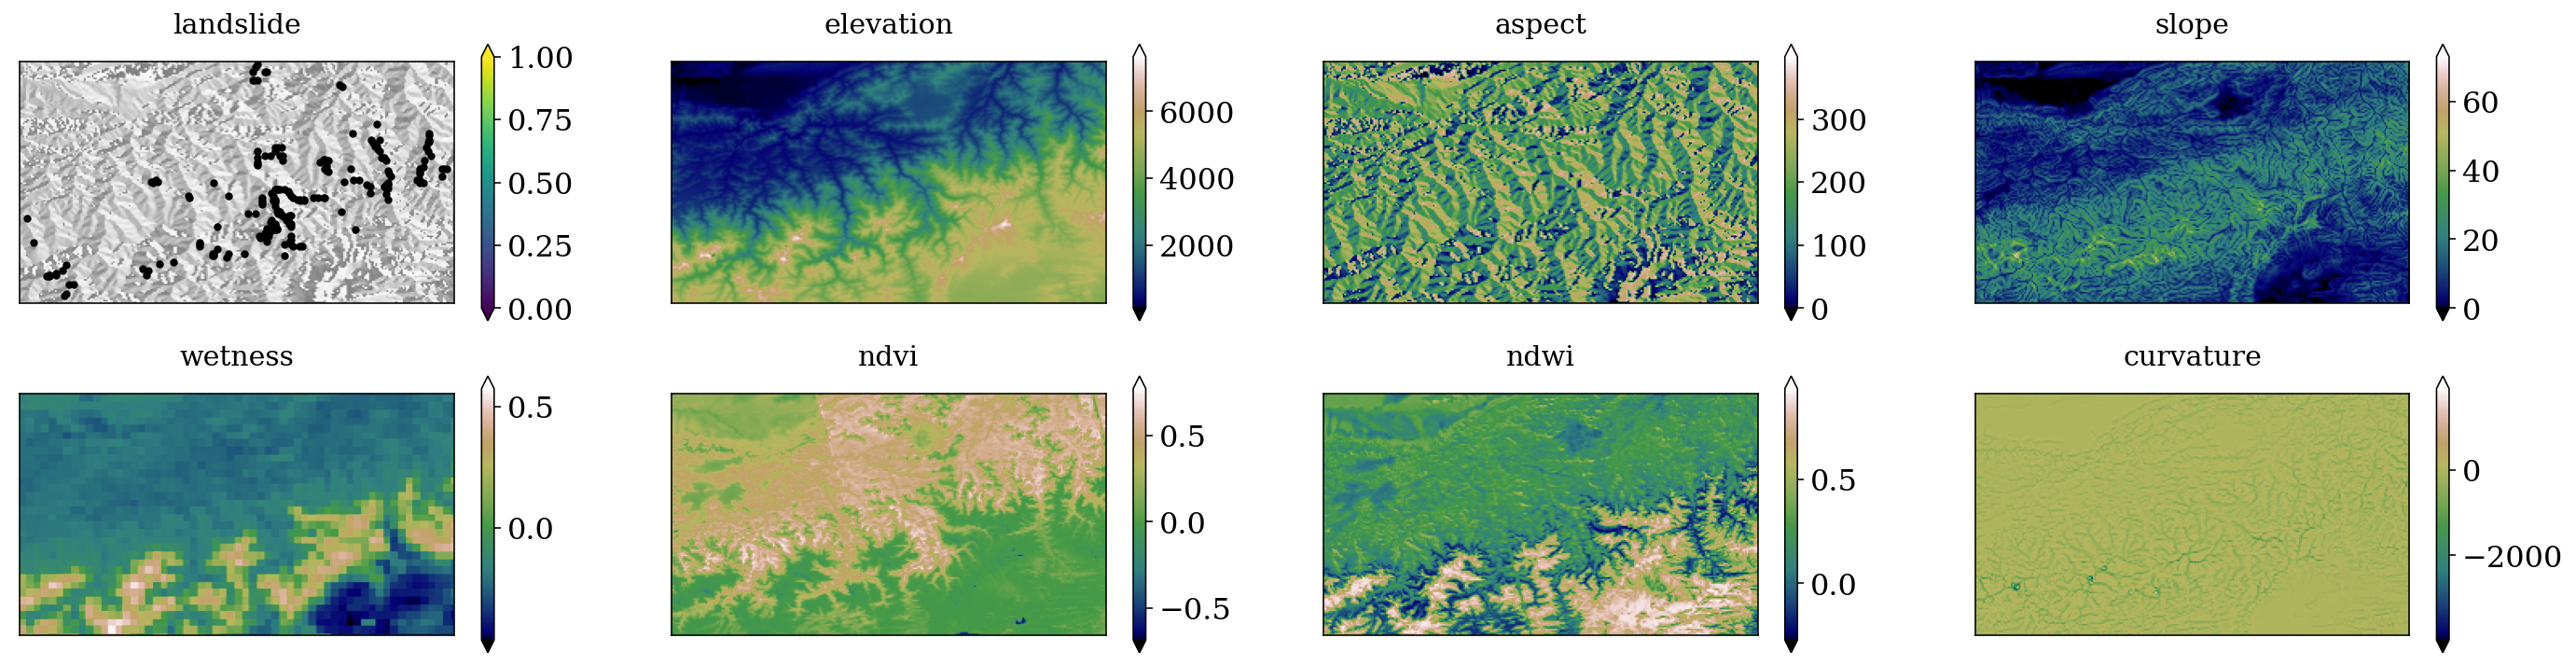

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(24, 6))
axs = axs.ravel()
for i in range(8):
    if i ==0:
      name = landslides_dataset.columns[i]
      plot = axs[i].imshow(landslides_dataset['aspect'].values.reshape(x_dim,y_dim).T, origin = 'lower', cmap = 'Greys_r', alpha=0.50)
      plot2 = axs[i].scatter(x=forPlot[forPlot['landslide']==1]['x'], y = forPlot[forPlot['landslide']==1]['y'],
            edgecolor='black', linewidth=1, facecolor='black',s=10)
      plt.colorbar(plot2,ax=axs[i],extend='both')
      axs[i].set_title(name, fontsize = 15)
      axs[i].set_xticks([])
      axs[i].set_yticks([])
    else:
      name = landslides_dataset.columns[i]
      plot = axs[i].imshow(landslides_dataset[name].values.reshape(x_dim,y_dim).T, origin = 'lower', cmap = 'gist_earth')
      plt.colorbar(plot,ax=axs[i],extend='both')
      axs[i].set_title(name, fontsize = 15)
      axs[i].set_xticks([])
      axs[i].set_yticks([])


Create Negative Lables

In [ ]:
logit_reg_landslide_neg = smf.logit("landslide ~ elevation + aspect + slope + wetness + ndvi + ndwi + curvature", data=landslides_dataset)
logit_reg_landslide_neg = logit_reg_landslide_neg.fit()

Optimization terminated successfully.
         Current function value: 0.028051
         Iterations 11


In [ ]:
np.random.seed(1234) 
threshold = 0.3
negative_labels_log_neg = logit_reg_landslide_neg.predict()<threshold 
nan_label = landslides_dataset['landslide'].values == 0.0
negative_labels_total = np.logical_and(negative_labels_log_neg,nan_label)
idx = np.flatnonzero(negative_labels_total)
chosen_idx = np.random.choice(idx, num_slide, replace=False)
landslides_dataset['landslide'][chosen_idx] = 2.0 # Assign value 2 as negative label

In [ ]:
landslides_dataset['landslide'].value_counts() #verify class balance

0.0    40084
2.0      208
1.0      208
Name: landslide, dtype: int64

In [ ]:
#Prepare dataset for next section
new_data_idx = np.logical_or(landslides_dataset['landslide'] == 1.0, landslides_dataset['landslide'] == 2.0)
new_landslides_dataset = landslides_dataset.loc[new_data_idx,:].reset_index(drop=True)
new_landslides_dataset['landslide'][new_landslides_dataset['landslide']==2.0]=0.0
new_landslides_dataset.head(3)

landslide  elevation  aspect  slope   wetness      ndvi      ndwi  curvature
0        0.0     1243.0     6.0    5.0 -0.226764  0.414061  0.224466     -186.0
1        0.0     1601.0   122.0   18.0 -0.139050  0.154317  0.211213      -66.0
2        0.0     1386.0   108.0    9.0 -0.139050  0.274120  0.223056       58.0

In [ ]:
new_landslides_dataset['landslide'].value_counts()

0.0    208
1.0    208
Name: landslide, dtype: int64

Map both positive and negative labels 

In [ ]:
forPlot = pd.DataFrame([], columns = ['x', 'y', 'landslide'])
forPlot['x'] =np.ravel(X)
forPlot['y'] = np.ravel(Y)
forPlot['landslide'] = np.ravel(landslides_dataset['landslide'].values.reshape(x_dim,y_dim).T)

([], <a list of 0 Text major ticklabel objects>)

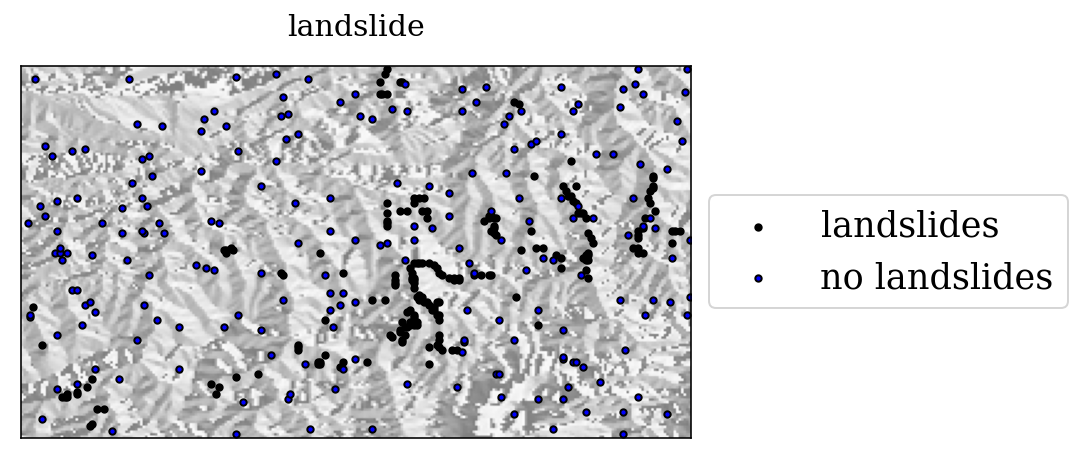

In [ ]:

i = 0
name = landslides_dataset.columns[0]
plot = plt.imshow(landslides_dataset['aspect'].values.reshape(x_dim,y_dim).T, origin = 'lower', cmap = 'Greys_r', alpha=0.50)
plot2 = plt.scatter(x=forPlot[forPlot['landslide']==1]['x'], y = forPlot[forPlot['landslide']==1]['y'],
      edgecolor='black', linewidth=1, facecolor='black',s=10, label="landslides")
plot2 = plt.scatter(x=forPlot[forPlot['landslide']==2]['x'], y = forPlot[forPlot['landslide']==2]['y'],
      edgecolor='black', linewidth=1, facecolor='blue',s=10, label="no landslides")
#plt.colorbar(plot2,extend='both')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title(name, fontsize = 15)
plt.xticks([])
plt.yticks([])

**Model 1: logistic regression (35pts) **

---



a. Now, let’s start with a logistic regression model with all seven predictors to produce a map of 
the posterior probability of landslide in each pixel. (5pts) 

In [ ]:
logit_reg_landslide = smf.logit("landslide ~ elevation + aspect + slope + wetness + ndvi + ndwi + curvature", data=new_landslides_dataset)
logit_reg_landslide = logit_reg_landslide.fit()

Optimization terminated successfully.
         Current function value: 0.476353
         Iterations 7


In [ ]:
print(logit_reg_landslide.summary())

                           Logit Regression Results                           
Dep. Variable:              landslide   No. Observations:                  416
Model:                          Logit   Df Residuals:                      408
Method:                           MLE   Df Model:                            7
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.3128
Time:                        03:50:20   Log-Likelihood:                -198.16
converged:                       True   LL-Null:                       -288.35
Covariance Type:            nonrobust   LLR p-value:                 1.625e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3035      0.759     -4.350      0.000      -4.792      -1.815
elevation      0.0006      0.000      4.367      0.000       0.000       0.001
aspect        -0.0024      0.002     -1.456      0.1

Text(0.5, 1.0, 'Landslides susceptibility prediction')

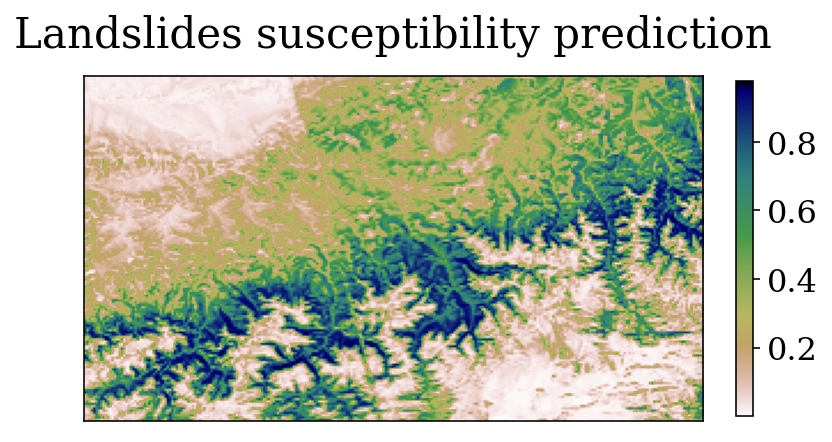

In [ ]:
#map of posterior probability
predict_entire_map = np.array(logit_reg_landslide.predict(landslides_dataset))
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(predict_entire_map.reshape(270,150).T, origin = 'lower', cmap = reversed_map)
plt.colorbar(fraction=0.025, pad=0.05)
plt.xticks([])
plt.yticks([])
plt.title('Landslides susceptibility prediction')

Text(0.5, 1.0, '> 0.3')

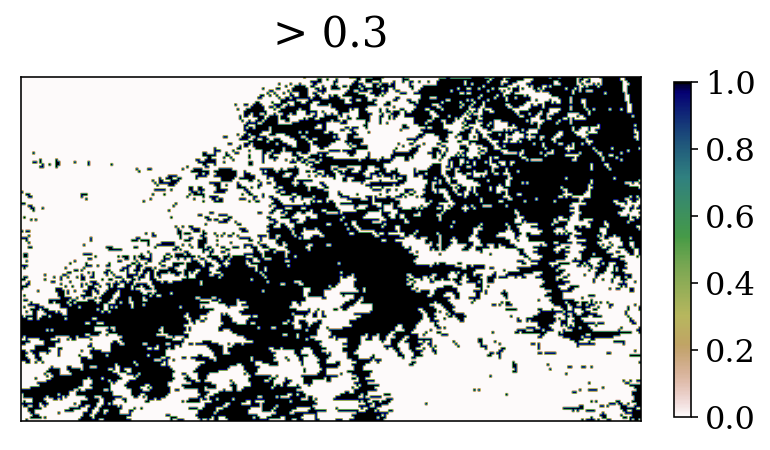

In [ ]:
#apply threshold
threshold = 0.3
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(predict_entire_map.reshape(270,150).T>threshold, origin = 'lower', cmap = reversed_map)
plt.colorbar(fraction=0.025, pad=0.05)
plt.xticks([])
plt.yticks([])
plt.title('> '+str(threshold))

**Colored graph is the right one!!**

b. How will the estimated odds change when the value of feature elevation is increased by 1 unit? 
No coding needed to do this (5pts) 


 

explination: odd 1 would stay the same but odd 2 would increase, making the overall estimated odd would decrease. 

Specifically, if you do some math, we see that the log of the equations for odd1 and odd2 are a sum of beta and x values. Thus, to negate the log we put those values as a power to e, in simplifying the now ratio of variables raised to the exponent of e it simplifies down to: e^-B1 or e to the negative beta 1 value. As beta 1 is associated with elevation. 

c. With the trained model from part 1.a, plot a confusion matrix on the data with a threshold equal 
to 0.3. How would you interpret the confusion matrix in this context? (5pts) 

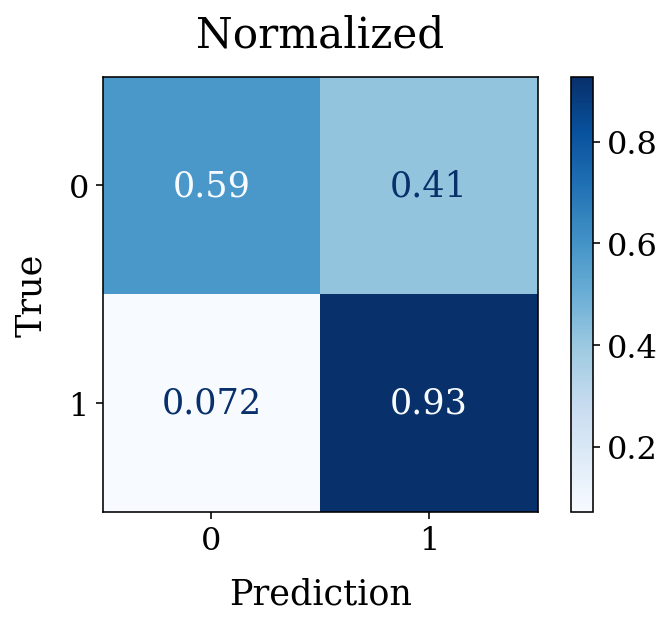

In [ ]:
threshold = 0.3
cm = confusion_matrix(new_landslides_dataset['landslide'].values, 
                     logit_reg_landslide.predict()>threshold, normalize= 'true')

class_label= ['0','1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Normalized')
plt.show()

interpretation:

In this context we only care about the true positives and true negatives. We see the true positves are high (.93) and the true neagtives are fairly high (.59). This means when we predict the landslide is going to happen that it has a high chance of happening. However, when we predict that the landslide will not happen there that it is less certainty. 




d. Choose a different threshold and again plot a confusion matrix. How do different thresholds 
affect the model prediction performance? (5pts) 

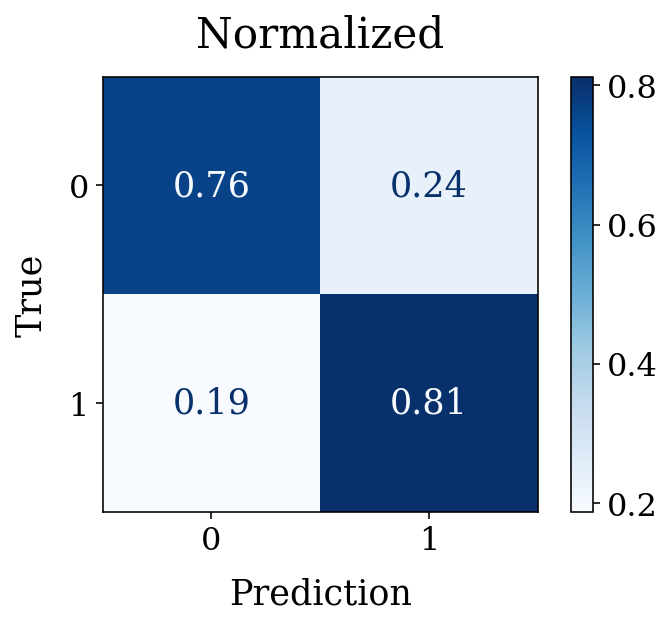

In [ ]:
threshold = 0.5
cm = confusion_matrix(new_landslides_dataset['landslide'].values, 
                     logit_reg_landslide.predict()>threshold, normalize= 'true')

class_label= ['0','1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Normalized')
plt.show()

observations: in raising the threshold we see a decrease in true positives to .81 and an increase in true negatives to .76. I think this model is better than the previous as it still has a high prediction rate for the event as well as much more power in predicting when the event will not happen. But this is related to what you care more about in predicting. 

I think our power in predicting a landslide will in fact happen is high and our ability to say a landslide will not happen is also rather high. 


e. Based on the output from part 1.a, which predictors are not statistically significant in association 
with landslide and why? (5pts) 

Predictors that are not significant in landslide prediction: wetness, curvature, and aspect becuase they have p values greater than .05 meaning they are not statistically significant. However, I will note that my outputs vary from the example notebook and in that notebook it shows aspect as also being statistically significant. 

For my graphs I will proceed with:

elevation + slope + ndvi + ndwi 



f. Fit a second logistic regression model without the feature(s) you mentioned from part 1.e. 
(5pts) 


In [ ]:
def precision_recall_LR(y_pred_prob,threshold,y_test):
    prediction = (y_pred_prob>threshold)
    TP = np.sum(prediction[y_test==1]) # 
    PP = np.sum(prediction) # predicted positive
    P = np.sum(y_test==1)# positive
    precision = TP/PP
    if np.isnan(precision):
        precision = 1
    recall = TP/P
    return [precision,recall]

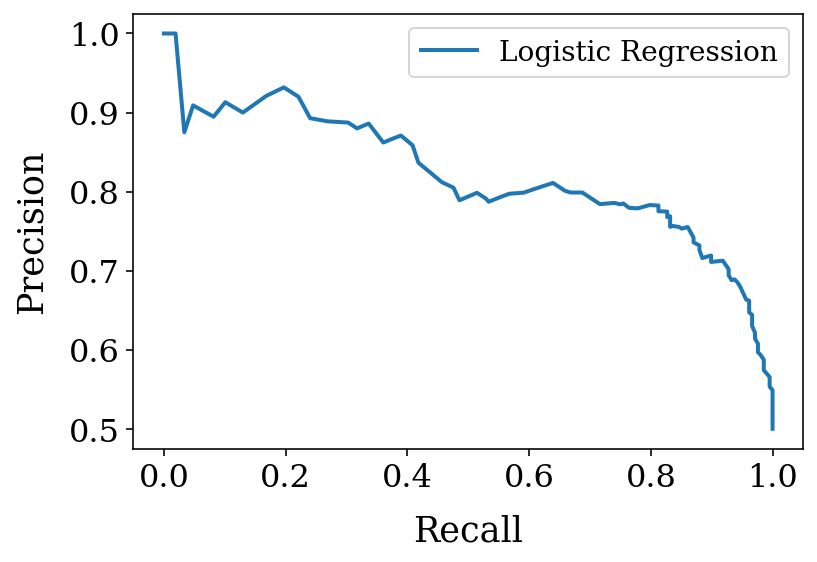

In [ ]:
PR = np.array([precision_recall_LR(logit_reg_landslide.predict(),threshold, y_test = new_landslides_dataset['landslide']) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0], label = 'Logistic Regression', linewidth=2)
plt.xlabel('Recall') # % positives successfully predicted
plt.ylabel('Precision')#: \n% positive predictions that are accurate
plt.legend(prop={'size': 14}, loc='upper right')

In [ ]:
logit_reg_landslide = smf.logit("landslide ~ elevation + slope + ndvi + ndwi", data=new_landslides_dataset)
logit_reg_landslide = logit_reg_landslide.fit()

Optimization terminated successfully.
         Current function value: 0.480417
         Iterations 7


In [ ]:
print(logit_reg_landslide.summary())

                           Logit Regression Results                           
Dep. Variable:              landslide   No. Observations:                  416
Model:                          Logit   Df Residuals:                      411
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.3069
Time:                        03:50:22   Log-Likelihood:                -199.85
converged:                       True   LL-Null:                       -288.35
Covariance Type:            nonrobust   LLR p-value:                 3.300e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5919      0.621     -5.782      0.000      -4.810      -2.374
elevation      0.0006      0.000      4.683      0.000       0.000       0.001
slope          0.0589      0.016      3.631      0.0

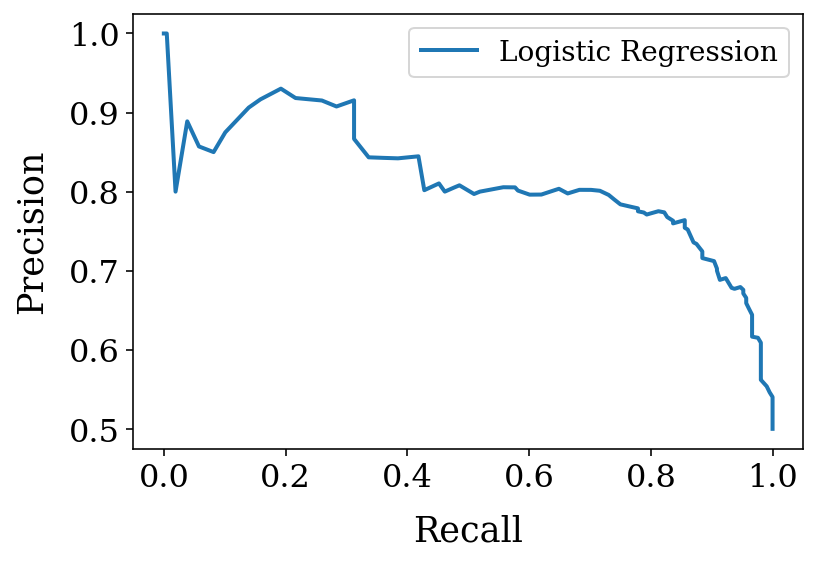

In [ ]:
PR = np.array([precision_recall_LR(logit_reg_landslide.predict(),threshold, y_test = new_landslides_dataset['landslide']) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0], label = 'Logistic Regression', linewidth=2)
plt.xlabel('Recall') # % positives successfully predicted
plt.ylabel('Precision')#: \n% positive predictions that are accurate
plt.legend(prop={'size': 14}, loc='upper right')

g. Which logistic regression model fits better (1.a vs 1.f) for this landslide dataset and why? (5pts) 

explanation: the logistic model from 1.f is better as it has generally higher precision across the plot. This means that the model has higher precision and is better at predicting the event. Additionally, the outputted chart for this model shows p values for all of the predictors as 0, meaning they are all statistically significant. This means the model is better and is not being affected by insignificant data. 

**Model 2: Naïve Bayes (30pts) **



---



a. Fit a Naïve Bayes classifier with a single predictor, wetness. Describe the posterior probability 
map? (5pts) 

In [ ]:
class_labels= ['0: no_landslide', '1: landslide']

train_smpls = {}
test_smpls = {}

y_X_df_train, y_X_df_test = train_test_split(new_landslides_dataset, test_size=0.2, random_state=1)
y_train = y_X_df_train['landslide'].values
y_test = y_X_df_test['landslide'].values
X_train = y_X_df_train.iloc[:,1:]
X_test = y_X_df_test.iloc[:,1:]

In [ ]:
prob_map = {}
pred_map = {}

test_pred = {}
test_prob = {}

In [ ]:
# calculate priors and likelihoods
priors = [np.sum(y_train==i)/len(y_train) for i in range(len(np.unique(y_train)))]

In [ ]:
# select one variable X
selected_evidence_layer = 'wetness'
X_train_one_variable = X_train[selected_evidence_layer].values
X_test_one_variable = X_test[selected_evidence_layer].values

# Calculate likelihood using KDE
likelihoods = [stats.gaussian_kde(X_train_one_variable[y_train==i])
               for i in range(len(np.unique(y_train)))]

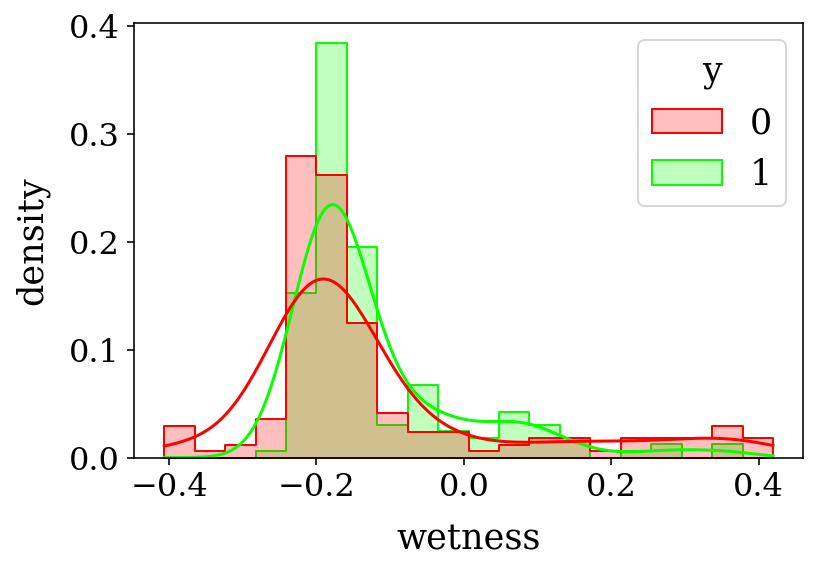

In [ ]:
X_train_pd = pd.DataFrame(X_train_one_variable, columns=[selected_evidence_layer])
X_train_pd['y'] = np.array(y_train,dtype = 'int64')
X_train_pd['weight'] = X_train_pd['y']
for i in range(len(np.unique(y_train))):
    X_train_pd['weight'][X_train_pd['y']==i] = 1/np.sum(X_train_pd['y']==i)

sns.histplot(data=X_train_pd, x=selected_evidence_layer, hue="y",stat="count", weights = 'weight',
             kde=True, palette = 'hsv',element="step", fill=True, bins = 20,hue_norm=(0,3))
plt.ylabel('density')
plt.show()

In [ ]:
def posterior_Bayes(x,likelihoods,priors):
    pos= [likelihoods[i](x)*priors[i] for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

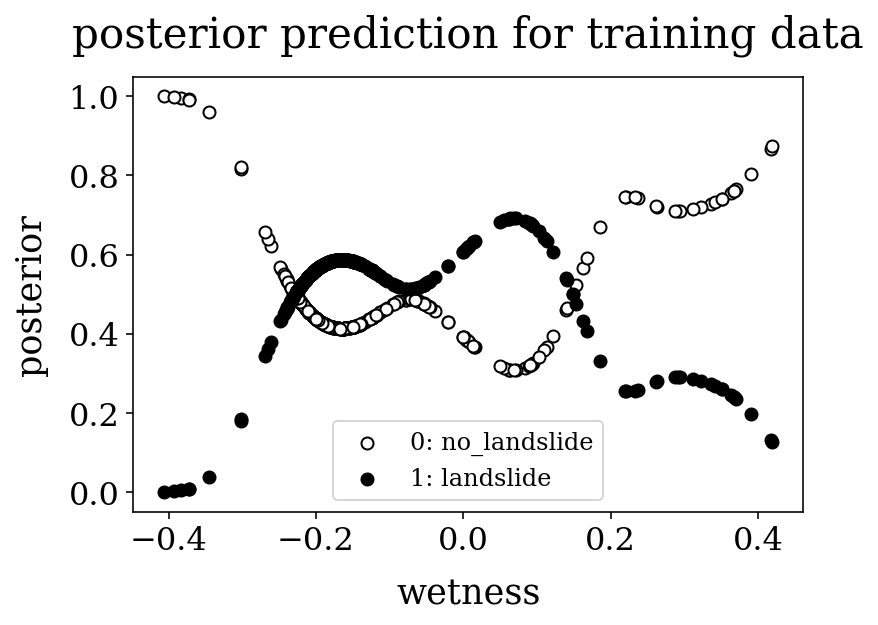

In [ ]:
Y_train_pos = posterior_Bayes(X_train_one_variable,likelihoods,priors)

plt.scatter(X_train_one_variable, Y_train_pos[:,0], c='w', edgecolor='k', label=class_labels[0])
plt.scatter(X_train_one_variable, Y_train_pos[:,1], c='k', label=class_labels[1])
plt.legend(prop={'size': 12})
plt.ylabel('posterior'), plt.xlabel(selected_evidence_layer)
plt.title('posterior prediction for training data')
plt.show()

In [ ]:
# Prediction of the posterior probability
prob_map['Bayes'] = posterior_Bayes(landslides_dataset[selected_evidence_layer], likelihoods, priors)

(Text(0, 0.5, 'km'), Text(0.5, 0, 'km'))

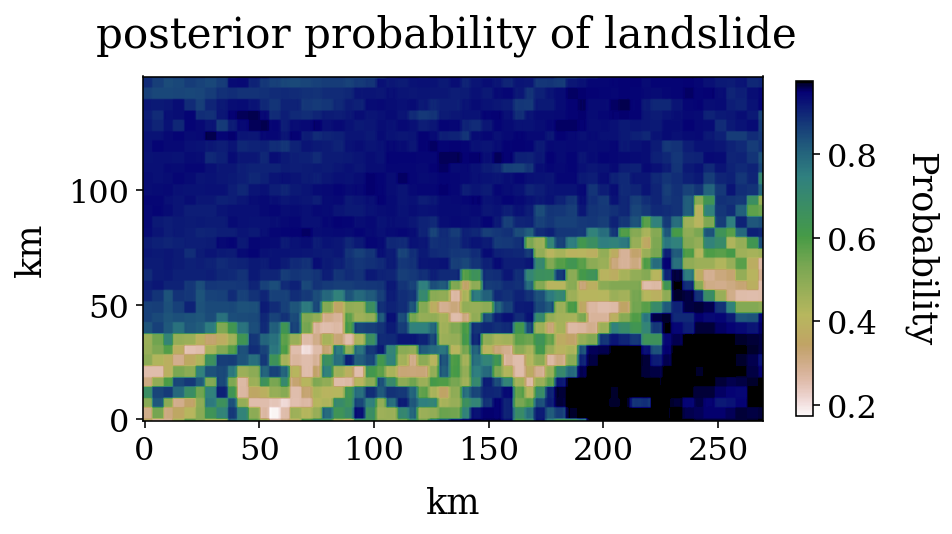

In [ ]:
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(prob_map['Bayes'][:,1].reshape(270,150).T, origin = 'lower', cmap = reversed_map)
cbar = plt.colorbar(fraction=0.025, pad=0.05)
cbar.ax.set_ylabel('Probability', rotation=270, labelpad=30)

plt.title('posterior probability of landslide ')
plt.ylabel('km'), plt.xlabel('km')

Description: we see high probabilities at the top of the graph and at the bottom right of the graph where wetness is very high. This reflects the single variable being wetness. 




b. With the trained model from 2.a, plot a confusion matrix with a threshold equal to 0.5. How 
would you interpret the confusion matrix in this context? (5pts) 

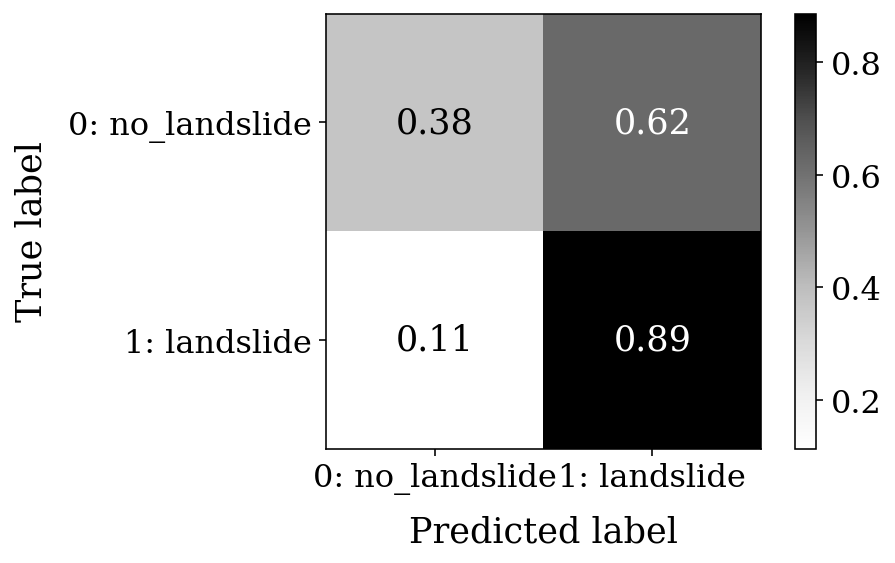

In [ ]:
test_prob['Bayes'] = posterior_Bayes(X_test_one_variable, likelihoods, priors)
threshold = 0.5
test_pred['Bayes']  = ((test_prob['Bayes'][:,1]>threshold)*1)

cm = confusion_matrix(np.array(y_test,dtype ='int64'), 
                      test_pred['Bayes'], labels=np.unique(test_pred['Bayes']), 
                      normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap = 'Greys')
plt.show()

The posterior probability map showes high true positives (.89) and low-ish true negatives (.38). 

In general the threshold may be too low so we consider too many values to indicate a landslide, hence why more often we predict no landslide as being a landslide (.62 vs .38). We could try and increase the threshold. 

c. Choose a different threshold and again plot a confusion matrix. How do different thresholds 
affect the Naïve Bayes prediction performance? (5pts) 

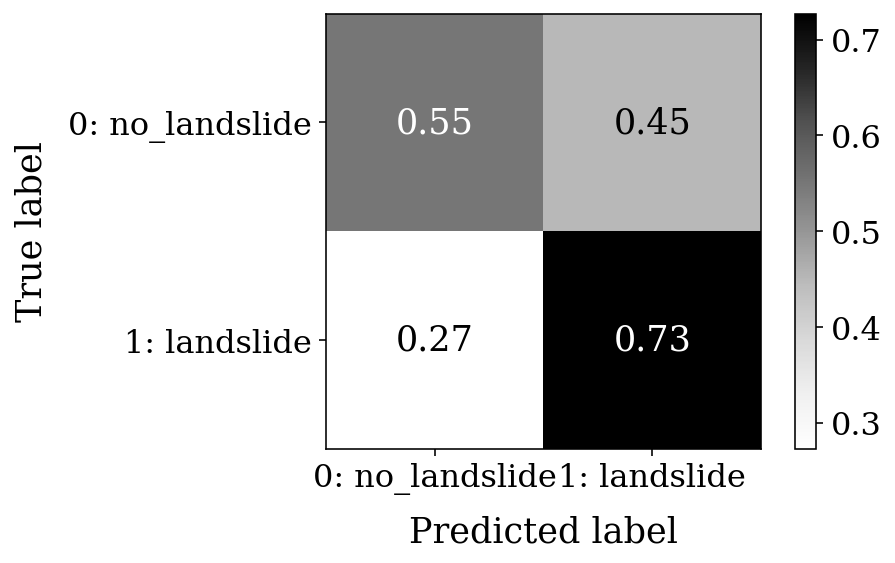

In [ ]:
threshold = 0.55 # Select a new threshold
test_prob['Bayes'] = posterior_Bayes(X_test_one_variable, likelihoods, priors)

test_pred['Bayes']  = ((test_prob['Bayes'][:,1]>threshold)*1)

cm = confusion_matrix(np.array(y_test,dtype ='int64'), 
                      test_pred['Bayes'], labels=np.unique(test_pred['Bayes']), 
                      normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap = 'Greys')
plt.show()

I raised the threshold to .55 and did see an increase in true negatives to .55, but a decrease in true positives to .73. This puts into question the trade-offs I want to make. I think that I am happier with this model but would like to improve it more with other methods. 


d. Use the trained Naïve Bayes model from part 2.a to produce a map of the posterior probability 
of landslide in each pixel. (5pts) 

In [ ]:
# Prediction of the posterior probability
prob_map['Bayes'] = posterior_Bayes(landslides_dataset[selected_evidence_layer], likelihoods, priors)

(Text(0, 0.5, 'km'), Text(0.5, 0, 'km'))

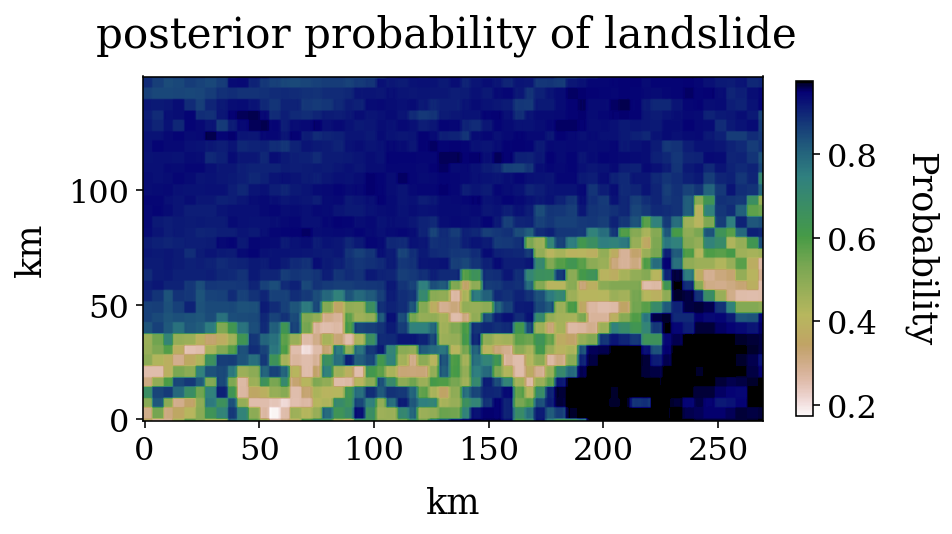

In [ ]:
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(prob_map['Bayes'][:,1].reshape(270,150).T, origin = 'lower', cmap = reversed_map)
cbar = plt.colorbar(fraction=0.025, pad=0.05)
cbar.ax.set_ylabel('Probability', rotation=270, labelpad=30)

plt.title('posterior probability of landslide ')
plt.ylabel('km'), plt.xlabel('km')

e. Fit a second Naïve Bayes classifier with two predictors, wetness and ndvi. Does this classifier 
better than the classifier with only wetness? Why? (5pts) 

In [ ]:
def precision_recall(y_pred_prob,threshold,y_test = y_test):
    prediction = (y_pred_prob[:,1]>threshold)
    TP = np.sum(prediction[y_test==1]) # 
    PP = np.sum(prediction) # predicted positive
    P = np.sum(y_test==1)# positive
    precision = TP/PP
    if np.isnan(precision):
        precision = 1
    recall = TP/P
    return [precision,recall]

In [ ]:
method = 'Naïve Bayes: x1,x2 '

In [ ]:
selected_evidence_layer_list = ['wetness','ndvi']
selected_index = [np.where(selected_evidence_layer_list==np.array(layer))[0][0] for layer in selected_evidence_layer_list]

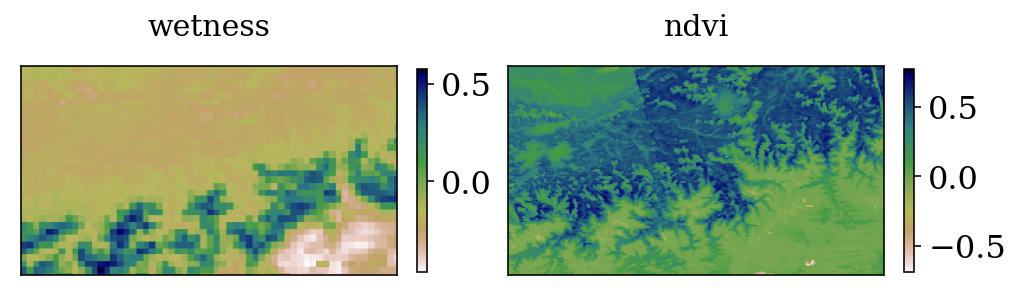

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 6))
axs = axs.ravel()
name = ['wetness','ndvi']
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
for i in range(2):

    plot = axs[i].imshow(landslides_dataset[name[i]].values.reshape(x_dim,y_dim).T, origin = 'lower', cmap = reversed_map)
    plt.colorbar(plot,ax=axs[i], fraction=0.025, pad=0.05)
    axs[i].set_title(name[i], fontsize = 15)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [ ]:
# calculate likelihoods
likelihoods_list = {}
for selected_layer in selected_evidence_layer_list:
    # selected_index = np.where(selected_band==np.array(name_list))[0][0]
    likelihoods = [stats.gaussian_kde(y_X_df_train[y_train==i][selected_layer])
                   for i in range(len(np.unique(y_train)))]
    likelihoods_list[selected_layer] = likelihoods

In [ ]:
# calculate the posterior p(c|x1,x2) = p(x1|c)p(x2|c)p(c)/p(x1,x2) 
def posterior_Naive(x, priors, likelihoods_list):
    selected_layer = selected_evidence_layer_list[0]
    likelihoods = likelihoods_list[selected_layer]
    pos= [likelihoods[i](x[selected_layer])*priors[i] for i in range(len(likelihoods))]
    for selected_layer in selected_evidence_layer_list[1:]:
        likelihoods = likelihoods_list[selected_layer]
        pos = [pos[i]*likelihoods[i](x[selected_layer]) for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

In [ ]:
X_train_two_variables = X_train[selected_evidence_layer_list]
X_test_two_variables = X_test[selected_evidence_layer_list]

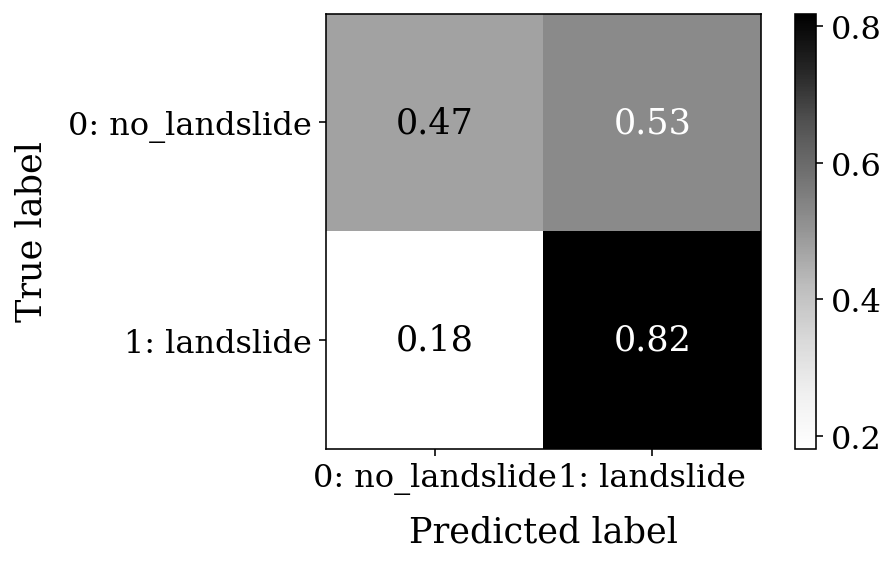

In [ ]:
test_prob_two_variables = {}
test_pred_two_variables = {}
test_prob_two_variables['Bayes'] = posterior_Naive(X_test_two_variables,priors,likelihoods_list)
threshold = 0.5
test_pred_two_variables['Bayes']  = ((test_prob_two_variables['Bayes'][:,1]>threshold)*1)
cm = confusion_matrix(np.array(y_test,dtype ='int64'), 
                      test_pred_two_variables['Bayes'], labels=np.unique(test_pred_two_variables['Bayes']), 
                      normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap = 'Greys')
plt.show()

Here we see lower true postives and high true negatives (.82 vs .89 and .47 vs .38)

In [ ]:
# Prediction of the posterior probability
prob_map_two_variables = {}
prob_map_two_variables['Bayes'] = posterior_Naive(landslides_dataset, priors,likelihoods_list)

Text(0, 0.5, 'Probability')

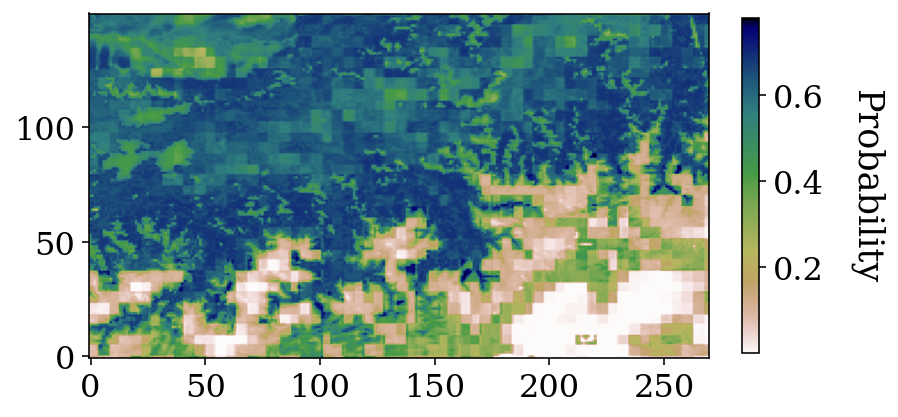

In [ ]:
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(prob_map_two_variables['Bayes'][:,1].reshape(270,150).T, origin = 'lower', cmap = reversed_map)
cbar = plt.colorbar(fraction=0.025, pad=0.05)
cbar.ax.set_ylabel('Probability', rotation=270, labelpad=30)

In the posterior probability map we also see a sharp change in its appearance. The bottom right has very low values while the top portion remains high. We see high values extending down where we see topography change in the map too. 

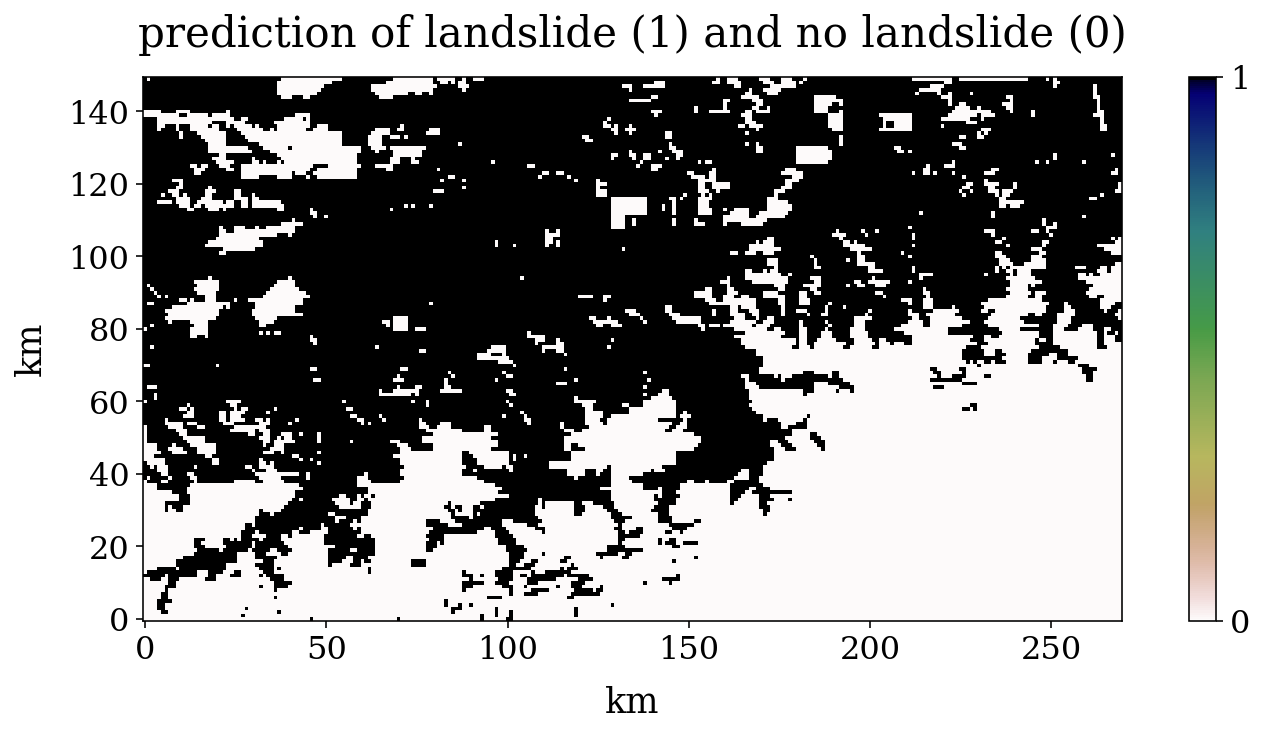

In [ ]:
threshold = 0.5
pred_map_allArea  = ((prob_map_two_variables['Bayes'][:,1]>threshold)*1).reshape(x_dim, y_dim)
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.figure(figsize=(12,5))
plt.imshow(pred_map_allArea.T, origin = 'lower', cmap = reversed_map)
plt.colorbar(ticks= [0,1], fraction=0.025, pad=0.05)
plt.title('prediction of landslide (1) and no landslide (0)')
plt.ylabel('km'), plt.xlabel('km')
# plt.axis('off')
plt.show()

In looking at the confusion matrix and the precision recall graphs, naive bayes with 2 variables seems to be much greater than naive bayes with 1 variable. We see this most sharply in their precision reflected below. I think that wetness is not a very significant variable and ndvi reveals much more information and that is why the 2 variable graph is better. I also think that limiting a prediction to 1 variable is a bad idea generally. Unless the events are mutually related, there is a direct causation, then you are simply predicting wetness not a landslide since it is a complex event

f. Plot the precision and recall analysis with the trained Naïve Bayes classifier from 2.e. (5pts) 

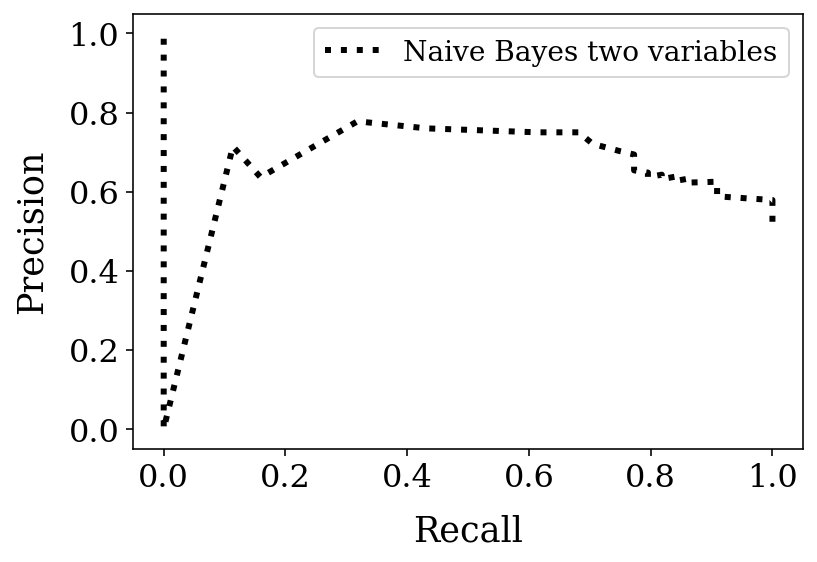

In [ ]:
PR = np.array([precision_recall(test_prob_two_variables['Bayes'], 
                                threshold,
                                y_test) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0],'k:', linewidth=3, label = 'Naive Bayes two variables')

plt.xlabel('Recall') #   % positives successfully predicted
plt.ylabel('Precision') # : \n% positive predictions that are accurate
plt.legend(prop={'size': 14})
plt.show()

In [ ]:
def precision_recall(y_pred_prob,threshold,y_test = y_test):
    prediction = (y_pred_prob[:,1]>threshold)
    TP = np.sum(prediction[y_test==1]) # 
    PP = np.sum(prediction) # predicted positive
    P = np.sum(y_test==1)# positive
    precision = TP/PP
    if np.isnan(precision):
        precision = 1
    recall = TP/P
    return [precision,recall]

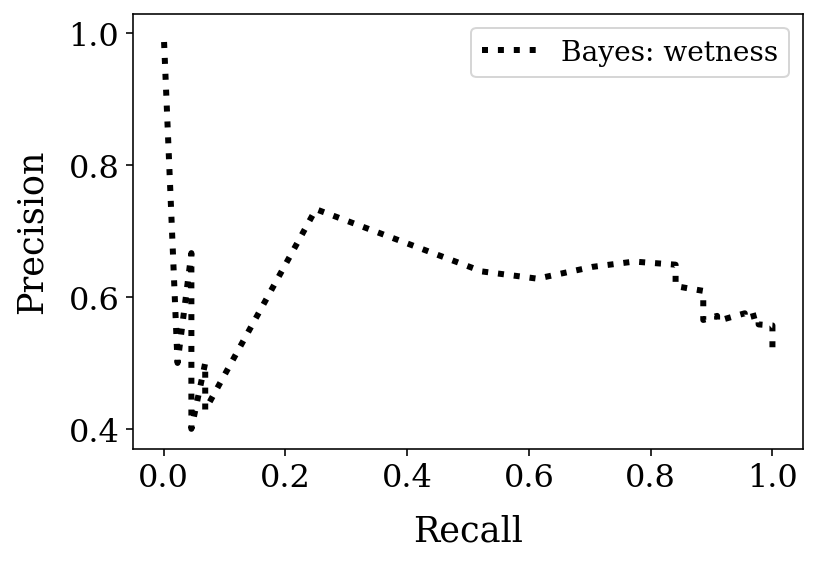

In [ ]:
PR = np.array([precision_recall(test_prob['Bayes'], 
                                threshold,
                                y_test) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0],'k:', linewidth=3, label = 'Bayes: ' + selected_evidence_layer)

plt.xlabel('Recall') #   % positives successfully predicted
plt.ylabel('Precision') # : \n% positive predictions that are accurate
plt.legend(prop={'size': 14})
plt.show()

**Model 3: Full Bayes (25pts) **

---



a. Fit a full Bayes classifier with the same two predictors as the naïve Bayes from 2.e, wetness and 
ndvi. (5pts) 

In [ ]:
# calculate likelihoods
likelihoods = [stats.gaussian_kde(y_X_df_train[y_train==i][selected_evidence_layer_list].T)
               for i in range(len(np.unique(y_train)))]

In [ ]:
# calculate the posterior p(c|x1,x2) = p(x1,x2|c)p(c)/p(x1,x2) 
def posterior_full_Bayes(x,likelihoods,priors):
#     selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
    pos= [likelihoods[i](x[selected_evidence_layer_list].T)*priors[i] for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

In [ ]:
prob_map_full_bayes = {}
prob_map_full_bayes['Bayes'] = posterior_full_Bayes(landslides_dataset,likelihoods, priors)

classify probability with a threshold value

In [ ]:
threshold = 0.5
pred_map_full_bayes = {}
pred_map_full_bayes['Bayes'] = ((prob_map_full_bayes['Bayes'][:,1]>threshold)*1)

b. Use the trained full Bayes classifier to produce a map of the posterior probability of landslide in 
each pixel. (5pts) 

Text(0, 0.5, 'Probability')

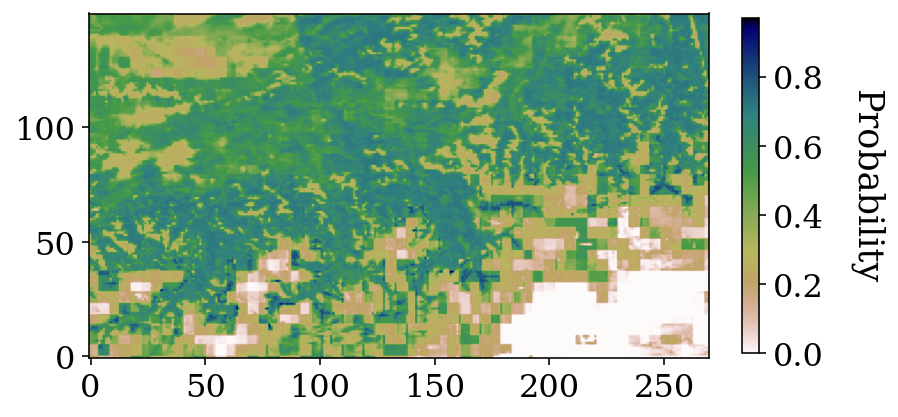

In [ ]:
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(prob_map_full_bayes['Bayes'][:,1].reshape(x_dim,y_dim).T, origin = 'lower', cmap = reversed_map)
cbar = plt.colorbar(fraction=0.025, pad=0.05)
cbar.ax.set_ylabel('Probability', rotation=270, labelpad=30)

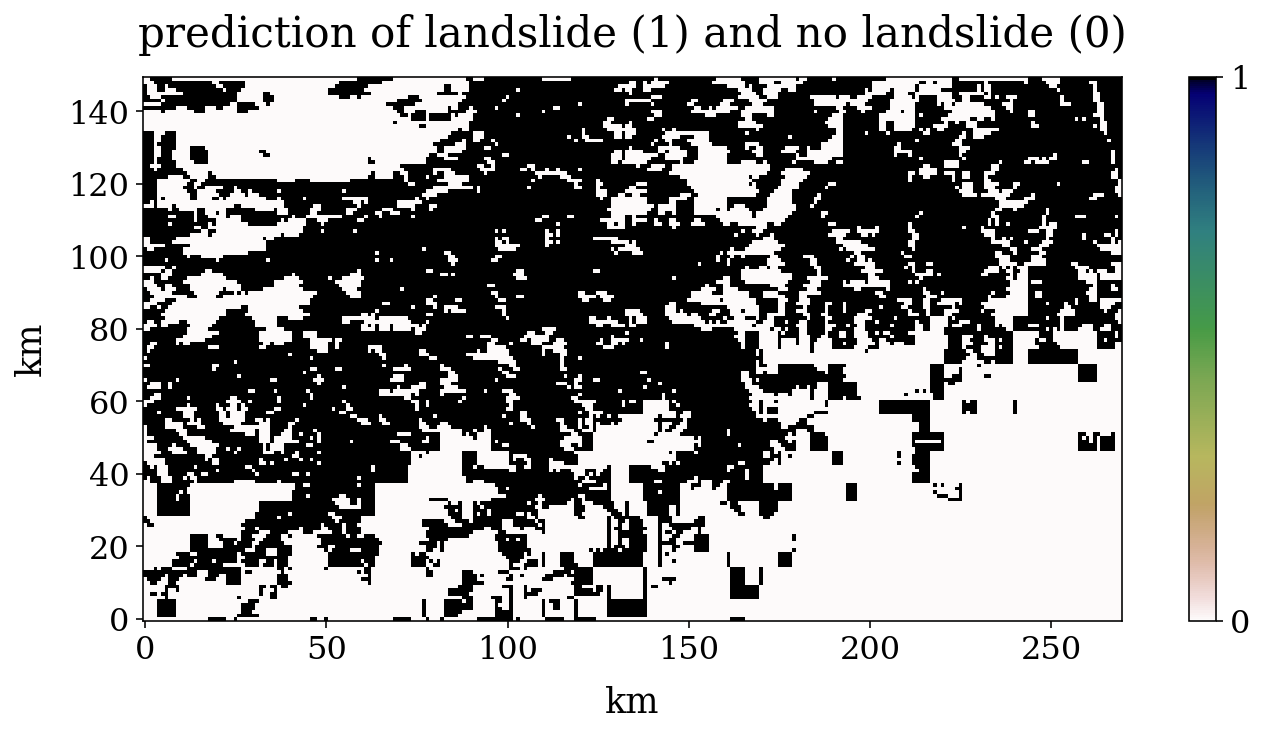

In [ ]:
threshold = 0.5
pred_map_allArea  = ((prob_map_full_bayes['Bayes'][:,1]>threshold)*1).reshape(x_dim, y_dim)
plt.figure(figsize=(12,5))
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(pred_map_allArea.T, origin = 'lower', cmap = reversed_map)
plt.colorbar(ticks= [0,1], fraction=0.025, pad=0.05)
plt.title('prediction of landslide (1) and no landslide (0)')
plt.ylabel('km'), plt.xlabel('km')
# plt.axis('off')
plt.show()

c. Plot the precision and recall analysis with the posterior probability from the trained Full Bayes 
classifier. (5pts) 

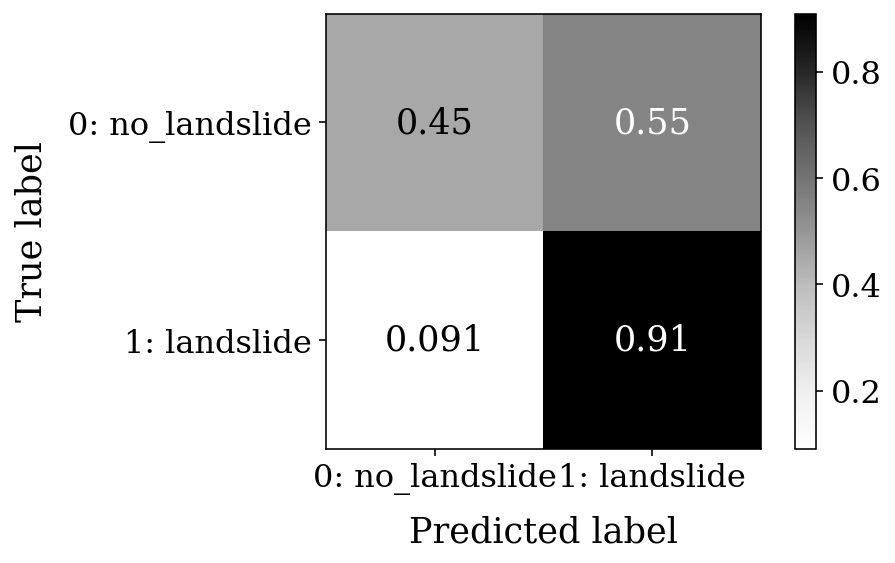

In [ ]:
threshold = 0.5 #Selected threshold

test_prob_full_bayes= posterior_full_Bayes(X_test_two_variables,likelihoods,priors)
test_pred_full_bayes = (test_prob_full_bayes[:,1]>threshold)*1

cm = confusion_matrix(np.array(y_test,dtype ='int64'), 
                      test_pred_full_bayes, 
                      labels=np.unique(test_pred_full_bayes), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap = 'Greys')
plt.show()

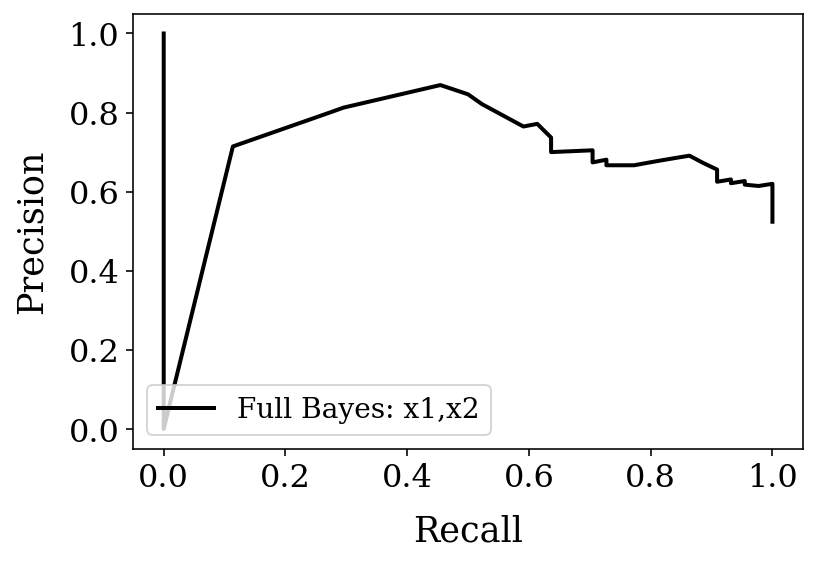

In [ ]:
method = "Full Bayes: x1,x2"
PR = np.array([precision_recall(test_prob_full_bayes,threshold) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0], 'k-', label = method, linewidth=2)

plt.xlabel('Recall') # % positives successfully predicted
plt.ylabel('Precision')#: \n% positive predictions that are accurate
plt.legend(prop={'size': 14}, loc='lower left')
plt.show()

d. Compare the precision and recall plot with 2.f. Do you think the chosen two features, wetness 
and ndvi, are conditional independent? Why? (10pts) 

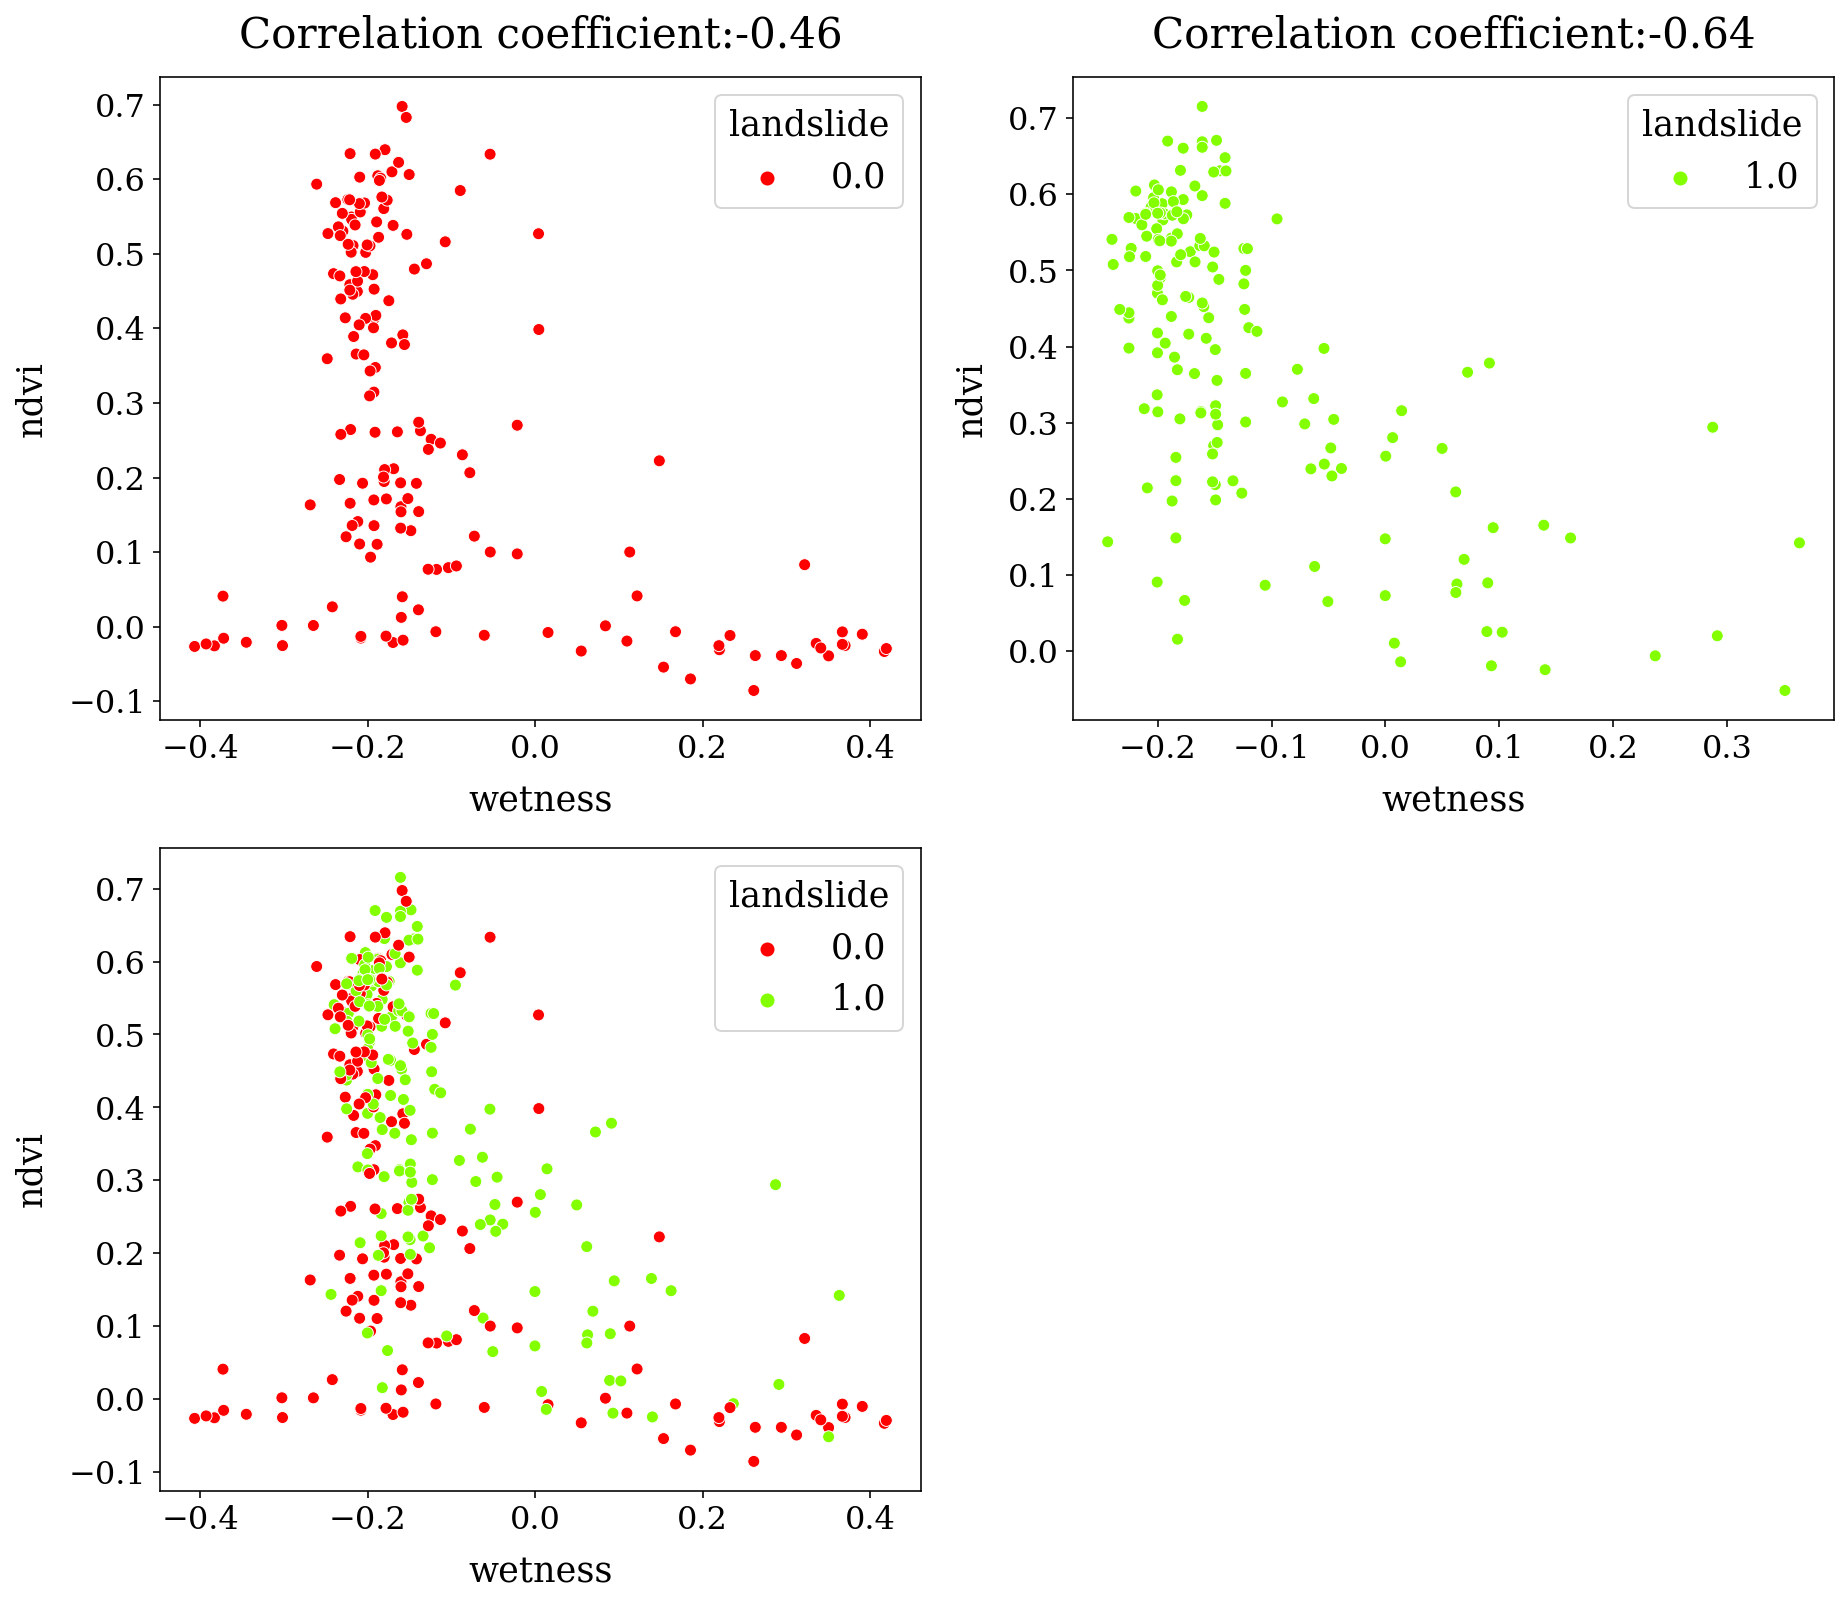

In [ ]:
plt.figure(figsize=(15,13))
for i in range(len(priors)): 
    ax = plt.subplot(2, 2, i+1)
    sns.scatterplot(data=y_X_df_train[y_X_df_train['landslide']==i], 
                    x=selected_evidence_layer_list[0], 
                    y=selected_evidence_layer_list[1],hue = 'landslide',palette = 'hsv',hue_norm=(0,4))
    corr = np.corrcoef(y_X_df_train[y_X_df_train['landslide']==i][selected_evidence_layer_list[0]],
                       y_X_df_train[y_X_df_train['landslide']==i][selected_evidence_layer_list[1]])[0,1]
    ax.set_title('Correlation coefficient:'+str(np.round(corr,2)))

ax = plt.subplot(2, 2, len(priors)+1)

sns.scatterplot(data=y_X_df_train, x=selected_evidence_layer_list[0],
                y=selected_evidence_layer_list[1],hue = 'landslide',palette = 'hsv',hue_norm=(0,4))
plt.show()

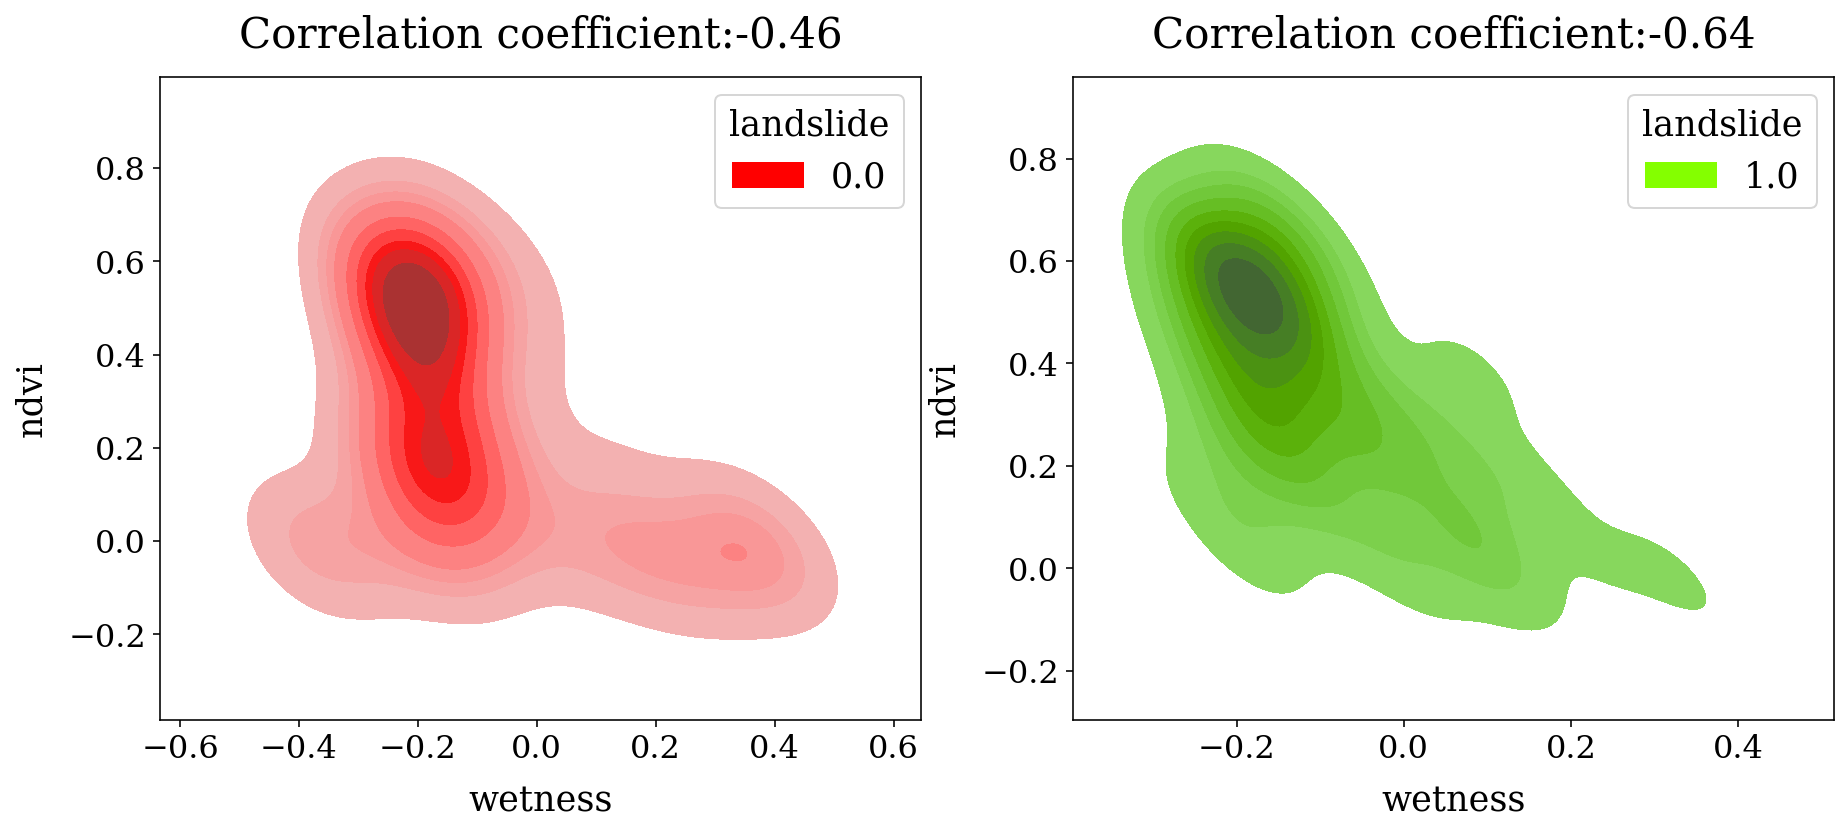

In [ ]:
plt.figure(figsize=(15,13))
for i in range(len(priors)): 
    ax = plt.subplot(2, 2, i+1)
    sns.kdeplot(data=y_X_df_train[y_X_df_train['landslide']==i], 
                    x=selected_evidence_layer_list[0], 
                    y=selected_evidence_layer_list[1], hue = 'landslide',palette = 'hsv',hue_norm=(0,4),fill=True)
    corr = np.corrcoef(y_X_df_train[y_X_df_train['landslide']==i][selected_evidence_layer_list[0]],
                       y_X_df_train[y_X_df_train['landslide']==i][selected_evidence_layer_list[1]])[0,1]
    ax.set_title('Correlation coefficient:'+str(np.round(corr,2)))

In comparing naive and full bayes, I think that the two predictors are not conditionally independent becuase the full bayes seems to be performing better than naive bayes. The full bayes has higher precision (seen below) and much higher true positives (from .82 to .91) with marginally lower true negatives (.47 to .45). It is much harder to go from .82 to .91 and a difference between .47 and .49 is not that large. We see this model performing much better than naive. 

In [ ]:
methods = ['Naïve Bayes: x1,x2', 'Full Bayes: x1,x2']

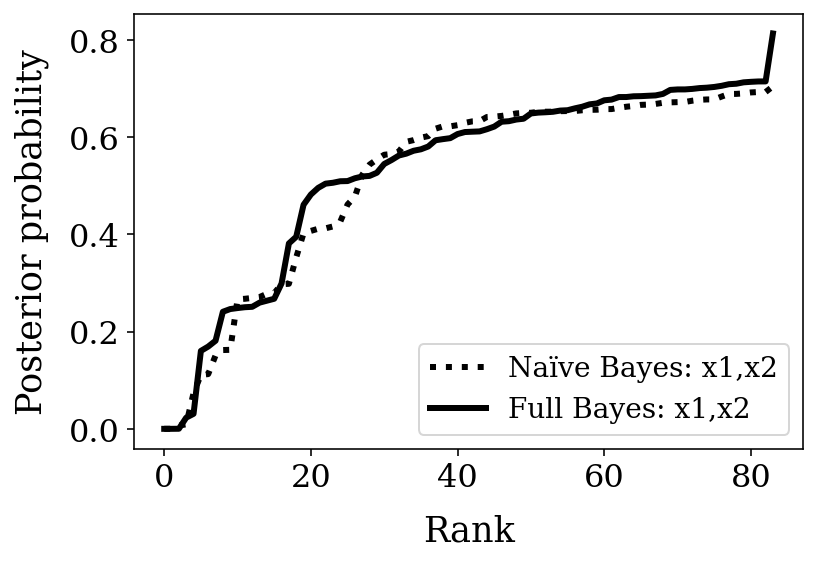

In [ ]:
plt.plot(np.sort(test_prob_two_variables['Bayes'][:,1]),'k:', label = methods[0], linewidth=3)
plt.plot(np.sort(test_prob_full_bayes[:,1]), 'k-', label = methods[1], linewidth=3)
plt.xlabel('Rank')
plt.ylabel('Posterior probability') 

plt.legend(prop={'size': 14})
plt.show()

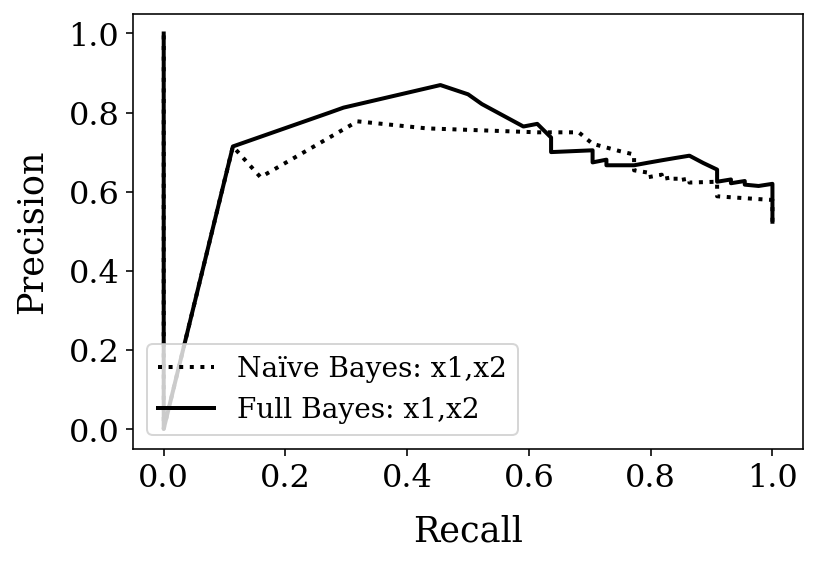

In [ ]:
line_styles = ['k:', 'k-']
# i=0
# for method in methods:
#     PR = np.array([precision_recall(test_prob_two_variables['Bayes'],threshold) for threshold in np.linspace(0,1,100)])
#     plt.plot(PR[:,1],PR[:,0], line_styles[i], label = method, linewidth=2)
#     i= i+1
PR = np.array([precision_recall(test_prob_two_variables['Bayes'],threshold) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0], line_styles[0], label = methods[0], linewidth=2)
PR = np.array([precision_recall(test_prob_full_bayes,threshold) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0], line_styles[1], label = methods[1], linewidth=2)
plt.xlabel('Recall') # % positives successfully predicted
plt.ylabel('Precision')#: \n% positive predictions that are accurate
plt.legend(prop={'size': 14}, loc='lower left')
plt.show()

Compare LR and Naïve Bayes both with 5 predictors (elevation, aspect, slope, ndvi, and ndwi). Which 
model has the best prediction on this dataset and why?  (10pts) 

In [ ]:
selected_evidence_layer_list = ['elevation', 'aspect', 'slope', 'ndvi', 'ndwi']
selected_index = [np.where(selected_evidence_layer_list==np.array(layer))[0][0] for layer in selected_evidence_layer_list]

In [ ]:
# calculate likelihoods
likelihoods_list = {}
for selected_layer in selected_evidence_layer_list:
    # selected_index = np.where(selected_band==np.array(name_list))[0][0]
    likelihoods = [stats.gaussian_kde(y_X_df_train[y_train==i][selected_layer])
                   for i in range(len(np.unique(y_train)))]
    likelihoods_list[selected_layer] = likelihoods

In [ ]:
# calculate the posterior 
def posterior_Naive(x, priors, likelihoods_list):
    selected_layer = selected_evidence_layer_list[0]
    likelihoods = likelihoods_list[selected_layer]
    pos= [likelihoods[i](x[selected_layer])*priors[i] for i in range(len(likelihoods))]
    for selected_layer in selected_evidence_layer_list[1:]:
        likelihoods = likelihoods_list[selected_layer]
        pos = [pos[i]*likelihoods[i](x[selected_layer]) for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

In [ ]:
X_train_all_variables = X_train[selected_evidence_layer_list]
X_test_all_variables = X_test[selected_evidence_layer_list]

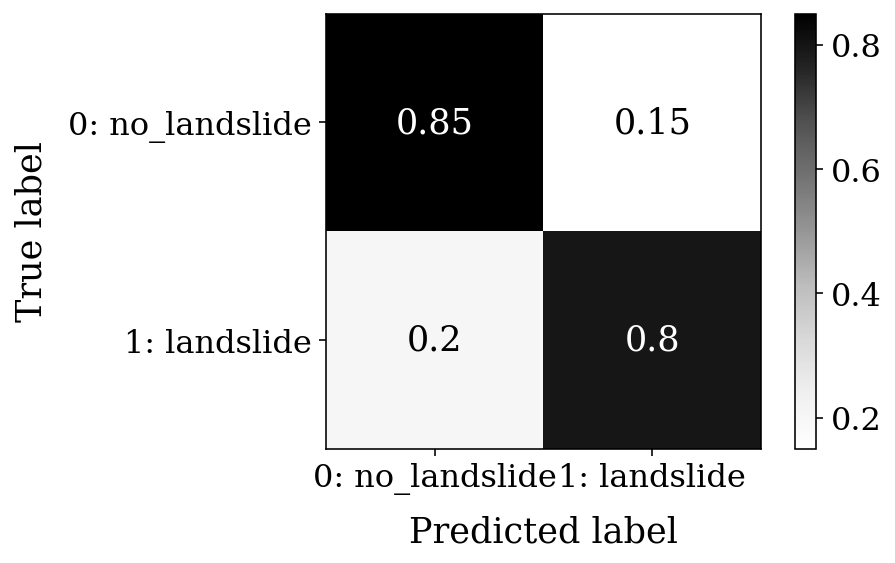

In [ ]:
test_prob_all_variables = {}
test_pred_all_variables = {}
test_prob_all_variables['Bayes'] = posterior_Naive(X_test_all_variables,priors,likelihoods_list)
threshold = 0.5
test_pred_all_variables['Bayes']  = ((test_prob_all_variables['Bayes'][:,1]>threshold)*1)
cm = confusion_matrix(np.array(y_test,dtype ='int64'), 
                      test_pred_all_variables['Bayes'], labels=np.unique(test_pred_all_variables['Bayes']), 
                      normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap = 'Greys')
plt.show()

In [ ]:
# Prediction of the posterior probability
prob_map_all_variables = {}
prob_map_all_variables['Bayes'] = posterior_Naive(landslides_dataset, priors,likelihoods_list)

Text(0, 0.5, 'Probability')

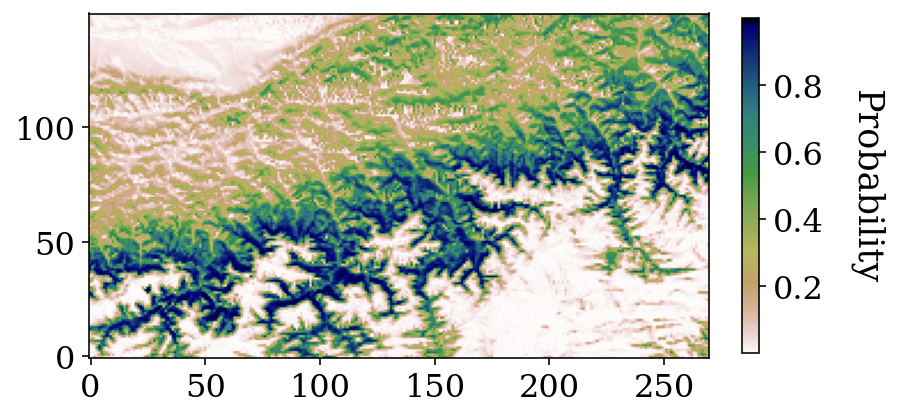

In [ ]:
orig_map=plt.cm.get_cmap('gist_earth')
reversed_map = orig_map.reversed()
plt.imshow(prob_map_all_variables['Bayes'][:,1].reshape(270,150).T, origin = 'lower', cmap = reversed_map)
cbar = plt.colorbar(fraction=0.025, pad=0.05)
cbar.ax.set_ylabel('Probability', rotation=270, labelpad=30)

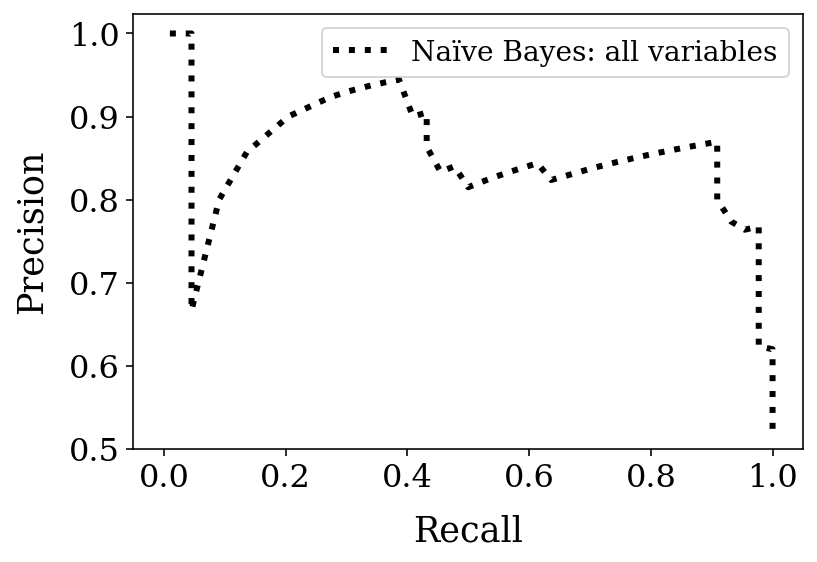

In [ ]:
PR = np.array([precision_recall(test_prob_all_variables['Bayes'], 
                                threshold,
                                y_test) for threshold in np.linspace(0,1,100)])
plt.plot(PR[:,1],PR[:,0],'k:', linewidth=3, label = 'Naïve Bayes: all variables')

plt.xlabel('Recall') #   % positives successfully predicted
plt.ylabel('Precision') # : \n% positive predictions that are accurate
plt.legend(prop={'size': 14})
plt.show()

Optimization terminated successfully.
         Current function value: 0.479352
         Iterations 7


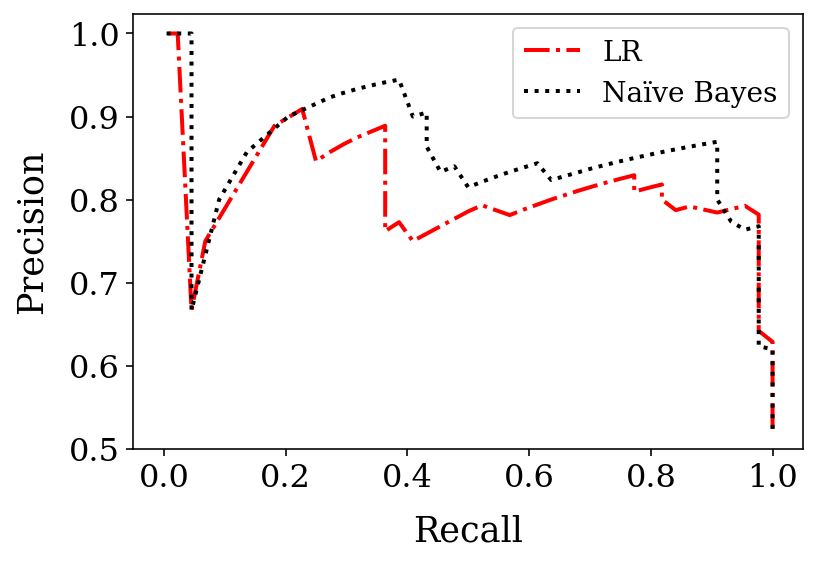

In [ ]:
line_styles = ['k-.', 'k:']
methods = ["LR","Naïve Bayes"]
colors = ["red","black"]

# logsitic regression with five varibles
logit_reg_landslide = smf.logit("landslide ~ elevation + aspect + slope + ndvi + ndwi", data=y_X_df_train)
logit_reg_landslide = logit_reg_landslide.fit()

PR_LR = np.array([precision_recall_LR(logit_reg_landslide.predict(X_test_all_variables),threshold, y_test ) for threshold in np.linspace(0,1,100)])
plt.plot(PR_LR[:,1],PR_LR[:,0], line_styles[0],label = methods[0], linewidth=2,color=colors[0])


PR_NB = np.array([precision_recall(test_prob_all_variables['Bayes'], 
                                threshold,
                                y_test) for threshold in np.linspace(0,1,100)])
plt.plot(PR_NB[:,1],PR_NB[:,0],line_styles[1], linewidth=2, label = methods[1],color=colors[1])

plt.xlabel('Recall') # % positives successfully predicted
plt.ylabel('Precision')#: \n% positive predictions that are accurate
plt.legend(prop={'size': 14}, loc='upper right')

In [ ]:
print("AUC of logistic regression: ", auc(PR_LR[:,1],PR_LR[:,0]))
print("AUC of Naïve Bayes: ", auc(PR_NB[:,1],PR_NB[:,0]))

AUC of logistic regression:  0.8108447760873371
AUC of Naïve Bayes:  0.8549463488491761


As seen in the outputs, naive bayes shows to have the better prediction for this dataset. The area under the curve for the precision of naive bayes with 5 variables is .85 vs .81 for LR. This shows high precision. This means that this model works better for this data and this event! 

Bonus (5pts): 
If you could access any datasets you want, list three potential new features that could improve the 
model predictions on occurrences of landslides?  Explain your choices. 

I would like access to rainfall records for the area, where rainfall occurs the most and at the fastest pace which is a huge cause of landslides, when the water overwhelms the substrate and causes it to slide. This could also help me normalize the wetness data and understand the exact relationship that exists with rainfall and landslides 

I would also like data on the soil composition or type, if it is say high in materials which are able to soak up water quickly and hold it, or if it is unable to filter water through and will get overwhelmed.

Lastly, I would like data on locations of roads and other human made features which not only impact the terrain but also signify greater risk of hazards and could allow me to fit the model to create high accuracy in that area. 
